In [3]:
import numpy as np
import netCDF4 as nc
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/transport_fluxes/')
import functions_transport_V

In [55]:
! ncdump -h /ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/1_mesh_mask.nc

netcdf \1_mesh_mask {
dimensions:
	x = 244 ;
	y = 274 ;
	z = 80 ;
	t = UNLIMITED ; // (1 currently)
variables:
	float nav_lon(y, x) ;
	float nav_lat(y, x) ;
	float nav_lev(z) ;
	double time_counter(t) ;
	byte tmask(t, z, y, x) ;
	byte umask(t, z, y, x) ;
	byte vmask(t, z, y, x) ;
	byte fmask(t, z, y, x) ;
	byte tmaskutil(t, y, x) ;
	byte umaskutil(t, y, x) ;
	byte vmaskutil(t, y, x) ;
	byte fmaskutil(t, y, x) ;
	float glamt(t, y, x) ;
	float glamu(t, y, x) ;
	float glamv(t, y, x) ;
	float glamf(t, y, x) ;
	float gphit(t, y, x) ;
	float gphiu(t, y, x) ;
	float gphiv(t, y, x) ;
	float gphif(t, y, x) ;
	double e1t(t, y, x) ;
	double e1u(t, y, x) ;
	double e1v(t, y, x) ;
	double e1f(t, y, x) ;
	double e2t(t, y, x) ;
	double e2u(t, y, x) ;
	double e2v(t, y, x) ;
	double e2f(t, y, x) ;
	double ff(t, y, x) ;
	short mbathy(t, y, x) ;
	short misf(t, y, x) ;
	float isfdraft(t, y, x) ;
	double e3t_0(t, z, y, x) ;
	double e3u_0(t, z, y, x) ;
	double e3v_0(t, z, y, x) ;
	double e3w_0(t, z, y, x) ;


In [49]:
def get_variables_planes(dirname, filename):
    with nc.Dataset(os.path.join(dirname, filename), 'r') as nbl:
        x, y =  slice(1,-1,None), slice(1,-1,None)
        gdepw = nbl.variables['gdepw_1d'][0, :]
        tmask = nbl.variables['tmask'][0, :, y, x]
        mbathy = nbl.variables['mbathy'][0, y, x]
        e1t = nbl.variables['e1t'][0, y, x]
        e2t = nbl.variables['e2t'][0, y, x]  
        return gdepw, tmask, mbathy, e1t, e2t

In [50]:
dirname = '/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'
filename = '1_mesh_mask.nc'
gdepw, tmask, mbathy, e1t, e2t = get_variables_planes(dirname, filename)
filename = '1_mesh_mask_nocanyon.nc'
gdepw0, tmask0, mbathy0, e1t0, e2t0 = get_variables_planes(dirname, filename)

In [51]:
mbathy.shape, e1t.shape, e2t.shape

((272, 242), (272, 242), (272, 242))

In [62]:
xs = np.arange(mbathy.shape[-1])
ys = np.arange(mbathy.shape[-2])
mbathy_diff = mbathy - mbathy0

In [90]:
axis_thalweg = np.zeros(mbathy_diff.shape[-2])
for y in range(len(axis_thalweg)):
    mbathy_row = mbathy_diff[y, :]
    max_mbathy_row = mbathy_row.max()
    x_inds_max_mbathy_row = np.where(mbathy_row == max_mbathy_row)[0]
    x_ind_thalweg = int(np.median(inds_max_mbathy_row))
    axis_thalweg[y] = x_ind_thalweg

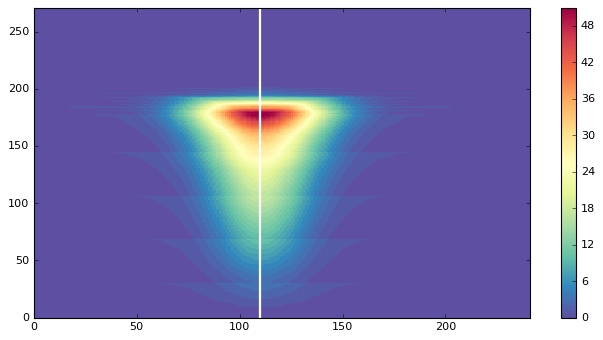

In [94]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
p = ax.pcolormesh(xs, ys, mbathy_diff, cmap=cm.Spectral_r)
ax.set_xlim(0, xs[-1]); ax.set_ylim(0, ys[-1])
fig.colorbar(p, ax=ax)

ax.plot(axis_thalweg, ys, c='w', linewidth=2)